In [1]:
## importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
stockdf= pd.read_csv('MSFT.csv')
stockdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9242 entries, 0 to 9241
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9242 non-null   object 
 1   Open       9242 non-null   float64
 2   High       9242 non-null   float64
 3   Low        9242 non-null   float64
 4   Close      9242 non-null   float64
 5   Adj Close  9242 non-null   float64
 6   Volume     9242 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 505.5+ KB


In [3]:
stockdf.head(n=3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060980,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063158,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064247,133171200


---

In [4]:
# to convert the str object type of date to datetime object
import datetime
def convert_date(date):
    split= date.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)
    

In [5]:
stockdf["Date"]= stockdf['Date'].apply(convert_date)

In [6]:
stockdf['Date'][0]

Timestamp('1986-03-13 00:00:00')

<AxesSubplot: >

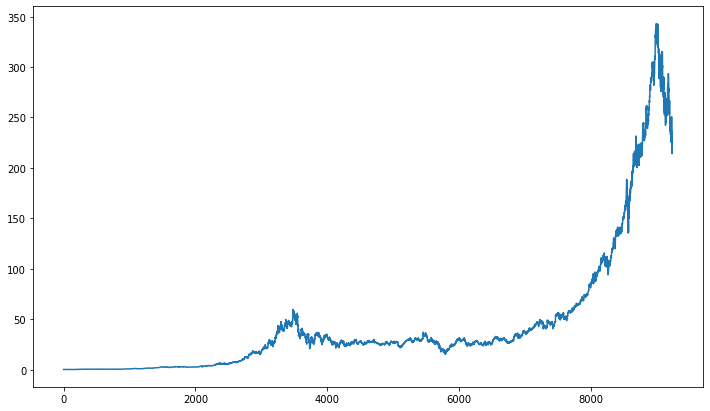

In [7]:
plt.figure(figsize=(12,7))
stockdf['Close'].plot()

In [8]:
# making dates as our index
stockdf.set_index('Date',inplace=True)
stockdf.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060980,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063158,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064247,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062613,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061524,47894400


In [9]:
stockdf.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-03,220.089996,220.410004,213.979996,214.250000,214.250000,36633900
2022-11-04,217.550003,221.589996,213.429993,221.389999,221.389999,36767800
2022-11-07,221.990005,228.410004,221.279999,227.869995,227.869995,33498000
2022-11-08,228.699997,231.649994,225.839996,228.869995,228.869995,28192500
2022-11-09,227.369995,228.630005,224.330002,224.509995,224.509995,27803000


# Training model

## Important Note ##
We do not take the 1986 data for Evaluation. LSTM model are not good at extrapolating. If we select the data from years father than the prediction dates, predictions will be inaccurate. 

Therefore we need to train the model near to the prediction date

In [10]:
# We will use the data to predict the close price.
# The data is converted into supervised learning data such that, the price of the stock is predicted using the data of previous three days

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    
    first_date = convert_date(first_date_str)
    last_date  = convert_date(last_date_str)

    target_date = first_date
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
        
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(stockdf, 
                                '2021-03-25', 
                                '2022-11-9', 
                                n=3)
windowed_df



,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
407,2022-11-03,232.130005,228.169998,220.100006,214.250000
408,2022-11-04,228.169998,220.100006,214.250000,221.389999
409,2022-11-07,220.100006,214.250000,221.389999,227.869995
410,2022-11-08,214.250000,221.389999,227.869995,228.869995


In [11]:
# the data is extracted as numpy array so as to be used in tensorflow

def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    Y = df_as_np[:, -1]
    
    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((412,), (412, 3, 1), (412,))

# Splitting the data for training,validation and testing

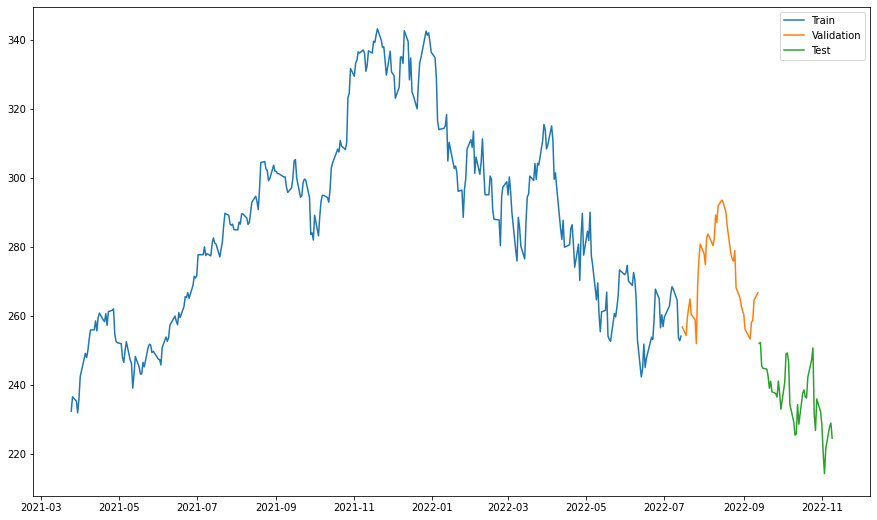

In [12]:
# we will use 80% of our data for training
train_len= int(len(dates)*0.8)
# from remaing data; 10% is used for validation
validation_len= int(len(dates)*0.9)
#remaining for testing

dates_train, X_train, y_train = dates[:train_len], X[:train_len], y[:train_len]
dates_val, X_val, y_val = dates[train_len:validation_len], X[train_len:validation_len], y[train_len:validation_len]
dates_test, X_test, y_test = dates[validation_len:], X[validation_len:], y[validation_len:]

plt.figure(figsize=(15,9))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

# Training the model

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [14]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
11/11 [==============================] - 7s 133ms/step - loss: 82471.5625 - mean_absolute_error: 285.8164 - val_loss: 73463.9844 - val_mean_absolute_error: 270.7486
Epoch 2/100
11/11 [==============================] - 0s 15ms/step - loss: 81921.0391 - mean_absolute_error: 284.8547 - val_loss: 72839.5312 - val_mean_absolute_error: 269.5928
Epoch 3/100
11/11 [==============================] - 0s 24ms/step - loss: 81177.5625 - mean_absolute_error: 283.5432 - val_loss: 71966.2188 - val_mean_absolute_error: 267.9682
Epoch 4/100
11/11 [==============================] - 0s 13ms/step - loss: 80057.0547 - mean_absolute_error: 281.5601 - val_loss: 70599.4844 - val_mean_absolute_error: 265.4054
Epoch 5/100
11/11 [==============================] - 0s 12ms/step - loss: 78256.8906 - mean_absolute_error: 278.3509 - val_loss: 68490.5391 - val_mean_absolute_error: 261.4026
Epoch 6/100
11/11 [==============================] - 0s 12ms/step - loss: 75800.1484 - mean_absolute_error: 273.8838 - 

11/11 [==============================] - 0s 11ms/step - loss: 86.1087 - mean_absolute_error: 6.8352 - val_loss: 51.3800 - val_mean_absolute_error: 5.9059
Epoch 49/100
11/11 [==============================] - 0s 11ms/step - loss: 77.2383 - mean_absolute_error: 6.4815 - val_loss: 44.2245 - val_mean_absolute_error: 5.3733
Epoch 50/100
11/11 [==============================] - 0s 11ms/step - loss: 69.1223 - mean_absolute_error: 6.2329 - val_loss: 29.1021 - val_mean_absolute_error: 4.3507
Epoch 51/100
11/11 [==============================] - 0s 11ms/step - loss: 61.4872 - mean_absolute_error: 5.7674 - val_loss: 35.3673 - val_mean_absolute_error: 4.8216
Epoch 52/100
11/11 [==============================] - 0s 11ms/step - loss: 56.1168 - mean_absolute_error: 5.6045 - val_loss: 78.4006 - val_mean_absolute_error: 7.6383
Epoch 53/100
11/11 [==============================] - 0s 12ms/step - loss: 64.2456 - mean_absolute_error: 6.2574 - val_loss: 55.1747 - val_mean_absolute_error: 6.1428
Epoch 54/10

11/11 [==============================] - 0s 11ms/step - loss: 34.5091 - mean_absolute_error: 4.6399 - val_loss: 39.3635 - val_mean_absolute_error: 4.8519
Epoch 98/100
11/11 [==============================] - 0s 10ms/step - loss: 41.9448 - mean_absolute_error: 5.2260 - val_loss: 30.1540 - val_mean_absolute_error: 4.5329
Epoch 99/100
11/11 [==============================] - 0s 10ms/step - loss: 52.2867 - mean_absolute_error: 5.7312 - val_loss: 48.4023 - val_mean_absolute_error: 5.7737
Epoch 100/100
11/11 [==============================] - 0s 11ms/step - loss: 35.9435 - mean_absolute_error: 4.7709 - val_loss: 28.3239 - val_mean_absolute_error: 4.2473


<AxesSubplot: >

<Figure size 864x504 with 0 Axes>

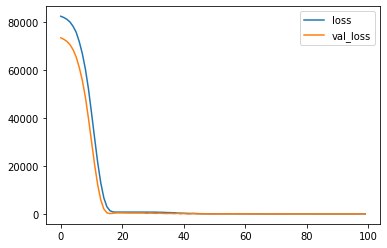

In [15]:
# ploting the losses for our model
plt.figure(figsize=(12,7))
losses=pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [16]:
losses.iloc[-1]

loss                       35.943504
mean_absolute_error         4.770894
val_loss                   28.323942
val_mean_absolute_error     4.247251
Name: 99, dtype: float64

11/11 [==============================] - 1s 4ms/step


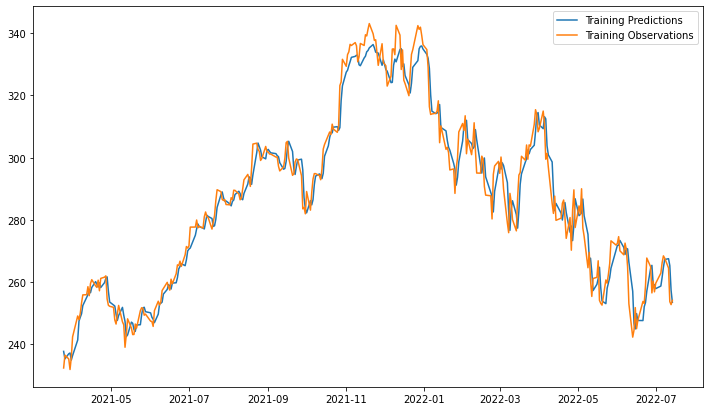

In [17]:
train_predictions = model.predict(X_train)

plt.figure(figsize=(12,7))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 4ms/step


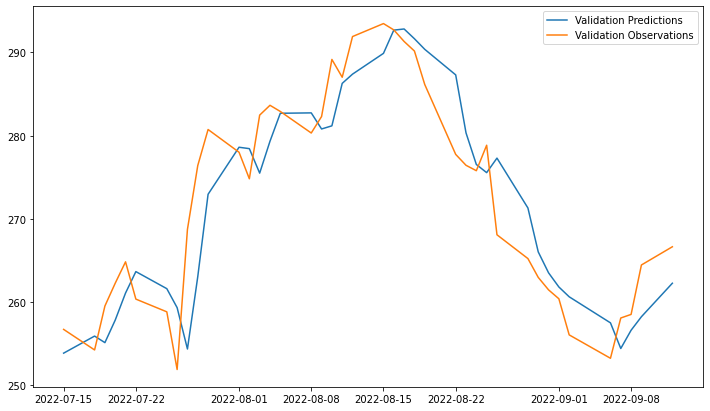

In [18]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(12,7))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 5ms/step


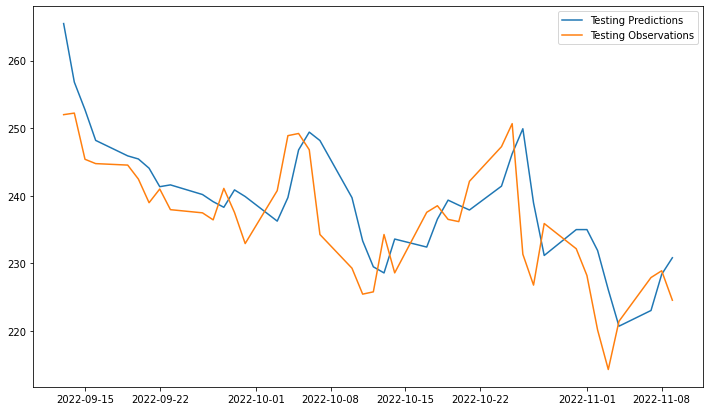

In [19]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(12,7))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

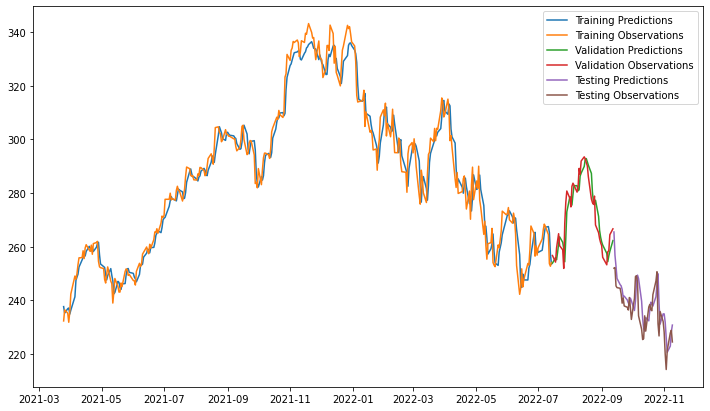

In [20]:
plt.figure(figsize=(12,7))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])


Using the above we can predict the values of those dates for which we have previous three dates data.
The LSTM model here is usefull to predict the stock prices on a micro basis. We cannot the predict the long term prices using the model here.

The model here will assume that the same price will continue in the future and will show a single value for long term future prediction.
***
***To understand this statement run the code given below***
```python
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])
recursive_dates
last_window = deepcopy(X_train[-1])

for target_date in recursive_dates:
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window[0]= last_window[1]
    last_window[1]=last_window[2]
    last_window[2]=next_prediction
```    
***
***and in another cell run the code below to compare the predictions using recurion with the true values***

```python
plt.figure(figsize=(12,7))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(recursive_dates,recursive_predictions)
plt.legend(['Testing Predictions', 
            'Testing Observations',
            'Validation Predictions', 
            'Validation Observations', 
            'Recursive Observations'])
```